In [1]:
import django, sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *

from scipy.spatial import ConvexHull

run_id = 662
s = 100000
p = 30

dto = DocDynamicTopic.objects

m = np.load('../tsne_results/data/run_{}_s_{}_m.npy'.format(run_id,s))
r_ind = np.load('../tsne_results/data/run_{}_s_{}_r_ind.npy'.format(run_id,s))
tsne_results = np.load('../tsne_results/data/run_{}_s_{}_p{}.npy'.format(run_id,s,p))

In [28]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.85,min_samples=150).fit(tsne_results)

labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 111


In [29]:
label_set = list(set(labels))
for l in set(labels):
    ind = np.argwhere(labels==l)
    print("\n##\nlabel: {}, {} documents".format(l,len(ind)))
    


##
label: 0, 447 documents

##
label: 1, 1373 documents

##
label: 2, 1872 documents

##
label: 3, 1859 documents

##
label: 4, 201 documents

##
label: 5, 1753 documents

##
label: 6, 2662 documents

##
label: 7, 851 documents

##
label: 8, 736 documents

##
label: 9, 1082 documents

##
label: 10, 1115 documents

##
label: 11, 2902 documents

##
label: 12, 708 documents

##
label: 13, 763 documents

##
label: 14, 2593 documents

##
label: 15, 754 documents

##
label: 16, 1350 documents

##
label: 17, 1791 documents

##
label: 18, 722 documents

##
label: 19, 827 documents

##
label: 20, 1669 documents

##
label: 21, 330 documents

##
label: 22, 1425 documents

##
label: 23, 608 documents

##
label: 24, 637 documents

##
label: 25, 538 documents

##
label: 26, 993 documents

##
label: 27, 1447 documents

##
label: 28, 1061 documents

##
label: 29, 596 documents

##
label: 30, 3137 documents

##
label: 31, 1293 documents

##
label: 32, 678 documents

##
label: 33, 1341 documents

##
la

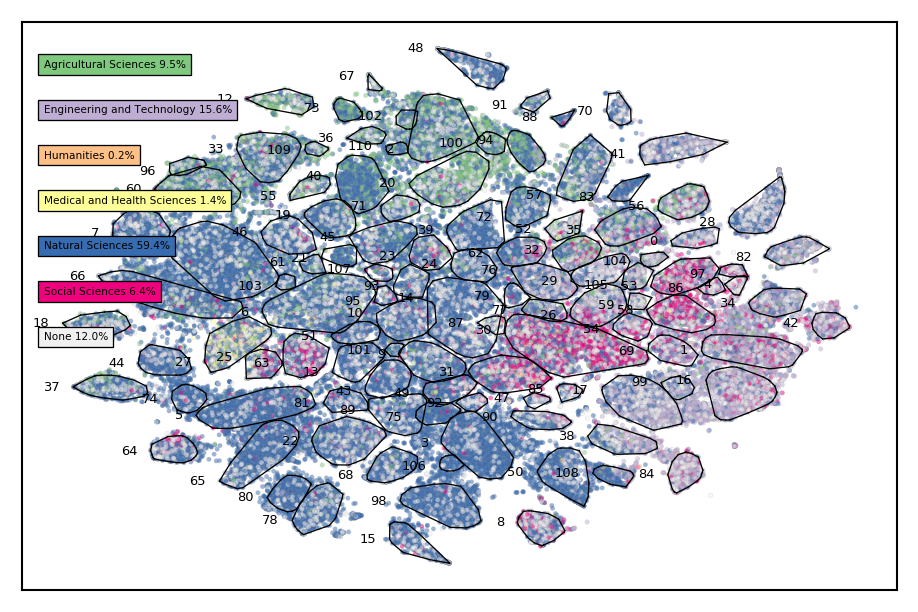

In [108]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)


import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(label_set), vmax=max(label_set))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

df = pd.DataFrame()

doc_df = pd.DataFrame()

colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
oecd_cats = list(Doc.objects.filter(id__in=r_ind).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=r_ind,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['color'] = colors[i]

for l in list(set(labels)):
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        col = "grey"
        for c in oecd_cats:
            if r_ind[did[0]] in c['docs']:
                col = c['color']
        cs.append(col)
        xs.append(x)
        ys.append(y)
        dids.append(r_ind[did[0]])
        
    cdocs = Doc.objects.filter(id__in=dids).values('title','PY')
    rows = pd.DataFrame.from_dict(list(cdocs))
    rows['cluster'] = l
    doc_df = doc_df.append(rows)
        
    dt = dto.filter(
        doc__id__in=dids,
        run_id=run_id
    ).aggregate(
        tscore=Sum('score')
    )

    dts = dto.filter(
        doc__id__in=dids,
        run_id=run_id
    ).values('topic__title').annotate(
        tscore=Sum('score'),
        tshare = Sum('score')/dt['tscore'],
        #cluster = l
    ).order_by('-tscore')

    rows = pd.DataFrame.from_dict(list(dts))
    rows['cluster'] = l
    df = df.append(rows)
        
    if l !=-1:
        points = np.array([(xs[i],ys[i]) for i,v in enumerate(xs)])
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            plt.plot(
                points[simplex, 0], 
                points[simplex, 1], 
                'k-',
                linewidth=0.5
            )
            for j in range(len(points[simplex,0])):                
                if i==0 and j==0:
                    px = points[simplex,0][j]
                    py = points[simplex,1][j]
                else:
                    if points[simplex,0][j] < px:
                        px = points[simplex,0][j]
                        py = points[simplex,1][j]                    

        plt.text(
            px-1,
            py,
            l,
            va="center",
            ha="right",
            fontsize=5
        )
        
    plt.scatter(
        xs,
        ys,
        s=3,
        alpha=0.5,
        #s=sizes,
        linewidth=0.1,
        c=cs,
        edgecolor='#a39c9c99'
    )
    
l = plt.xlim()[0]
t = plt.ylim()[1]
yextent = plt.ylim()[1]- plt.ylim()[0]
ysp = yextent*0.08

for i,c in enumerate(oecd_cats):
    plt.text(
        l*0.95,
        t-ysp-i*ysp,
        "{} {:.1%}".format(c['wc__oecd'],len(c['docs'])/len(r_ind)),
        fontsize=4,
        bbox={
            'facecolor': c['color'],
            'pad': 2,
            'lw': 0.5
        }
    )

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,  
    labelbottom=False,
    left=False,
    labelleft=False
)
            
plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_clusters.png'.format(run_id,s,p))
plt.show()



In [110]:
df
df.to_csv('../tsne_results/data/run_{}_s_{}_p{}_clusters.png'.format(run_id,s,p))

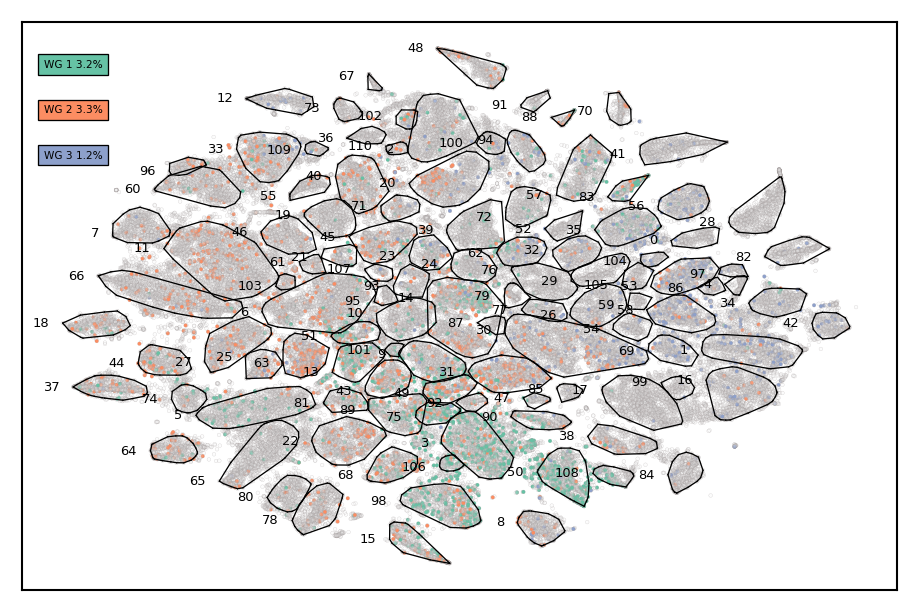

In [107]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)

colors=["#66c2a5","#fc8d62","#8da0cb"]



wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    c['docs'] = list(Doc.objects.filter(
        id__in=r_ind,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True))
    c['color'] = colors[i]

for l in list(set(labels)):
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    alphas=[]
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        col = "#F0F0F026"
        al = 0.5
        for c in wgs:
            if r_ind[did[0]] in c['docs']:
                col = c['color']
                al = 1
        alphas.append(al)
        cs.append(col)
        xs.append(x)
        ys.append(y)
        dids.append(r_ind[did[0]])
        
    cdocs = Doc.objects.filter(id__in=dids).values('title','PY')
    rows = pd.DataFrame.from_dict(list(cdocs))
    rows['cluster'] = l
    doc_df = doc_df.append(rows)
        
    if l !=-1:
        points = np.array([(xs[i],ys[i]) for i,v in enumerate(xs)])
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            plt.plot(
                points[simplex, 0], 
                points[simplex, 1], 
                'k-',
                linewidth=0.5
            )
            for j in range(len(points[simplex,0])):                
                if i==0 and j==0:
                    px = points[simplex,0][j]
                    py = points[simplex,1][j]
                else:
                    if points[simplex,0][j] < px:
                        px = points[simplex,0][j]
                        py = points[simplex,1][j]                    

        plt.text(
            px-1,
            py,
            l,
            va="center",
            ha="right",
            fontsize=5
        )
        
    plt.scatter(
        xs,
        ys,
        s=3,
        #alpha=alphas,
        #s=sizes,
        linewidth=0.1,
        c=cs,
        edgecolor='#a39c9c99'
    )
    
l = plt.xlim()[0]
t = plt.ylim()[1]
yextent = plt.ylim()[1]- plt.ylim()[0]
ysp = yextent*0.08

for i,c in enumerate(wgs):
    plt.text(
        l*0.95,
        t-ysp-i*ysp,
        "WG {} {:.1%}".format(c['wg'],len(c['docs'])/len(r_ind)),
        fontsize=4,
        bbox={
            'facecolor': c['color'],
            'pad': 2,
            'lw': 0.5
        }
    )

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,  
    labelbottom=False,
    left=False,
    labelleft=False
)
            
plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_clusters_wgs.png'.format(run_id,s,p))
plt.show()

In [104]:
for i,c in enumerate(wgs):
    plt.text(
        l*0.95,
        t-ysp-i*ysp,
        "WG {} {:.1%}".format(c['wg'],len(c['docs'])/len(r_ind)),
        fontsize=4,
        bbox={
            'facecolor': c['color'],
            'pad': 2,
            'lw': 0.5
        }
    )
    


array([6.02148815e-03, 1.05233333e+03, 1.20428155e-02, ...,
       4.01435351e-03, 1.20431371e-02, 4.01433819e-03])

In [61]:
cl = 98
df[(df['cluster']==cl) & (df['tshare']>0.01)].head()

,topic__title,tscore,tshare,cluster
0,"{ice, sheet, arctic}",104.248894,0.348085,98
1,"{record, dure, holocen}",23.726906,0.079224,98
2,"{sea, level, rise}",21.273443,0.071032,98
3,"{model, predict, use}",7.344605,0.024523,98
4,"{ocean, marin, atmospher}",6.876732,0.022961,98


In [59]:
for i, row in doc_df[doc_df['cluster']==cl].head().iterrows():
    print(row['title'])

Addressing drought conditions under current and future climates in the Jordan River region
Dendroclimatic Reconstruction at Kilometer-Scale Grid Points: A Case Study from the Great Basin of North America
Impacts of upstream drought and water withdrawals on the health and survival of downstream estuarine oyster populations
Partial net primary production of a mixed dipterocarp forest: Spatial patterns and temporal dynamics
Drought adversely affects tuber development and nutritional quality of the staple crop cassava (Manihot esculenta Crantz)


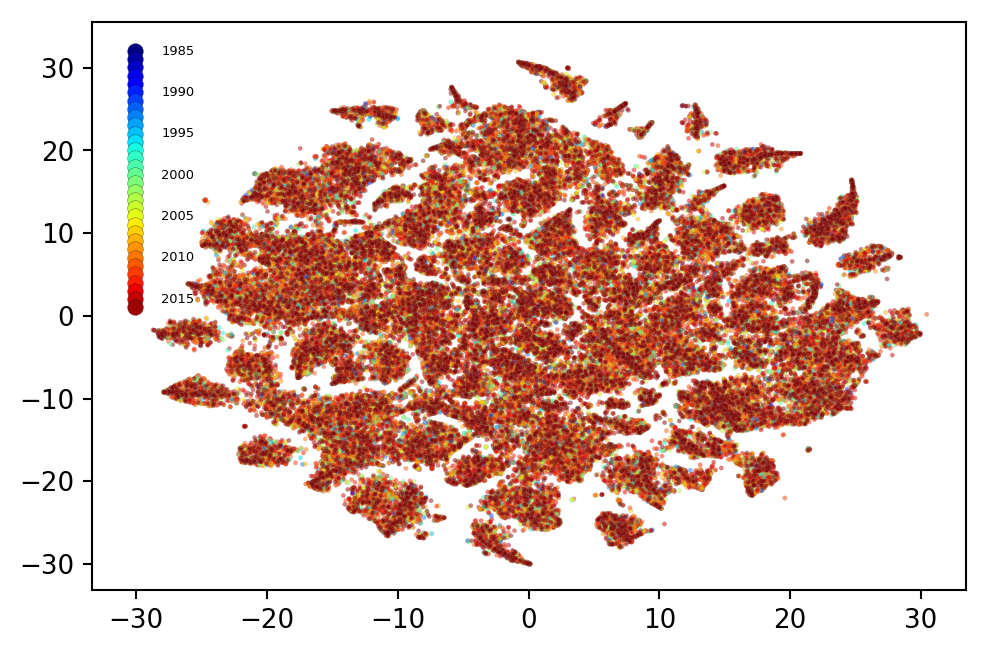

In [65]:
cs = []
sizes = []
xs = []
ys = []
fig = plt.figure(dpi=188)

years = list(Doc.objects.filter(
    id__in=r_ind
).values_list('PY',flat=True))

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(years), vmax=max(years))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)


for i,did in enumerate(r_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = scalarMap.to_rgba(years[i])
    cs.append(col)
    xs.append(x)
    ys.append(y)
        

plt.scatter(
    xs,
    ys,
    s=3,
    alpha=0.5,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='#a39c9c66'
)

i = 0

l = plt.xlim()[0]
t = plt.ylim()[1]

for y in range(scalarMap.get_clim()[0],scalarMap.get_clim()[1]):
    plt.scatter(
        l*0.95,
        t*0.95-i*1,
        c=scalarMap.to_rgba(y),
        linewidth=0.1,
        edgecolor='k'
        
    )
    if y % 5 == 0:
        plt.text(
            l*0.95+2,
            t*0.95-i*1,
            y,
            fontsize=5,
            va="center",
            ha="left"
        )
    i+=1

plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_time.png'.format(run_id,s,p))

plt.show()


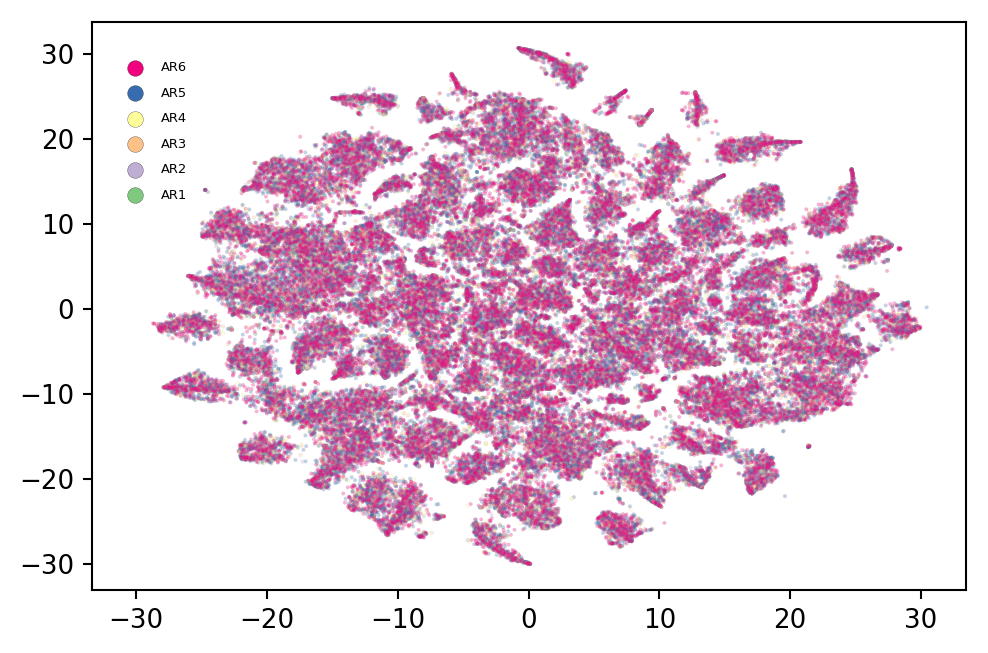

In [92]:
cs = []
sizes = []
xs = []
ys = []
fig = plt.figure(dpi=188)

years = list(Doc.objects.filter(
    id__in=r_ind
).values_list('PY',flat=True))

aps = []
ars = list(scoping.models.AR.objects.filter(ar__gt=0).order_by('-ar').values())
arcolours = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc']

arcolours = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']

for y in years:
    ap = "#F0F0F0"
    for ar in ars:
        if y >= ar['start'] and y <= ar['end']:
            ap = arcolours[ar['ar']-1]
            break
    aps.append(ap)
    
    

for i,did in enumerate(r_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    xs.append(x)
    ys.append(y)
        

plt.scatter(
    xs,
    ys,
    s=2,
    alpha=0.3,
    #s=sizes,
    linewidth=0.1,
    c=aps,
    edgecolor='#a39c9c66'
)

i = 0

l = plt.xlim()[0]
t = plt.ylim()[1]

yextent = plt.ylim()[1]- plt.ylim()[0]
ysp = yextent*0.08

for ar in ars:
    plt.scatter(
        l*0.95,
        t-ysp-i*3,
        c=arcolours[ar['ar']-1],
        linewidth=0.1,
        edgecolor='k'
        
    )
    plt.text(
        l*0.95+2,
        t-ysp-i*3,
        ar['name'],
        fontsize=5,
        va="center",
        ha="left"
    )
    i+=1
    

plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_ars.png'.format(run_id,s,p))

plt.show()

[{'ar': 6, 'end': 9998, 'id': 7, 'name': 'AR6', 'start': 2014},
 {'ar': 5, 'end': 2013, 'id': 5, 'name': 'AR5', 'start': 2008},
 {'ar': 4, 'end': 2007, 'id': 4, 'name': 'AR4', 'start': 2001},
 {'ar': 3, 'end': 2000, 'id': 3, 'name': 'AR3', 'start': 1995},
 {'ar': 2, 'end': 1994, 'id': 2, 'name': 'AR2', 'start': 1991},
 {'ar': 1, 'end': 1990, 'id': 1, 'name': 'AR1', 'start': 1985}]